<a href="https://www.kaggle.com/code/yorkyong/housing-price-prediction-data-eda-ml?scriptVersionId=156785380" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

In [2]:
df = pd.read_csv('/kaggle/input/housing-price-prediction-data/housing_price_dataset.csv')

# **Step 1: Understanding the Data**

In [3]:
df.shape

(50000, 6)

In [4]:
df.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB


* Data looks clean with no missing data or presence of weird data formats

In [6]:
df.describe()

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Price
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2006.374680,3.498700,1.995420,1985.404420,224827.325151
std,575.513241,1.116326,0.815851,20.719377,76141.842966
min,1000.000000,2.000000,1.000000,1950.000000,-36588.165397
25%,1513.000000,3.000000,1.000000,1967.000000,169955.860225
50%,2007.000000,3.000000,2.000000,1985.000000,225052.141166
75%,2506.000000,4.000000,3.000000,2003.000000,279373.630052
max,2999.000000,5.000000,3.000000,2021.000000,492195.259972


* Price field looks strange with minimum starting at negative, to dive further on it

In [7]:
#shows as well for non-numeric fields
df.describe(include=['O'])

,Neighborhood
count,50000
unique,3
top,Suburb
freq,16721


# **Step 2: Data Preparation**

In [8]:
df.loc[df.duplicated()]

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price


In [9]:
#Drop all price that are less than 0
df = df[df['Price'] >= 0]

* No duplicated data found

# **Step 3: Feature Understanding**

In [10]:
df['Neighborhood'].value_counts()

Neighborhood
Suburb    16716
Rural     16668
Urban     16594
Name: count, dtype: int64

* Neighbourhood field seems to be quite evenly spread among the three categories

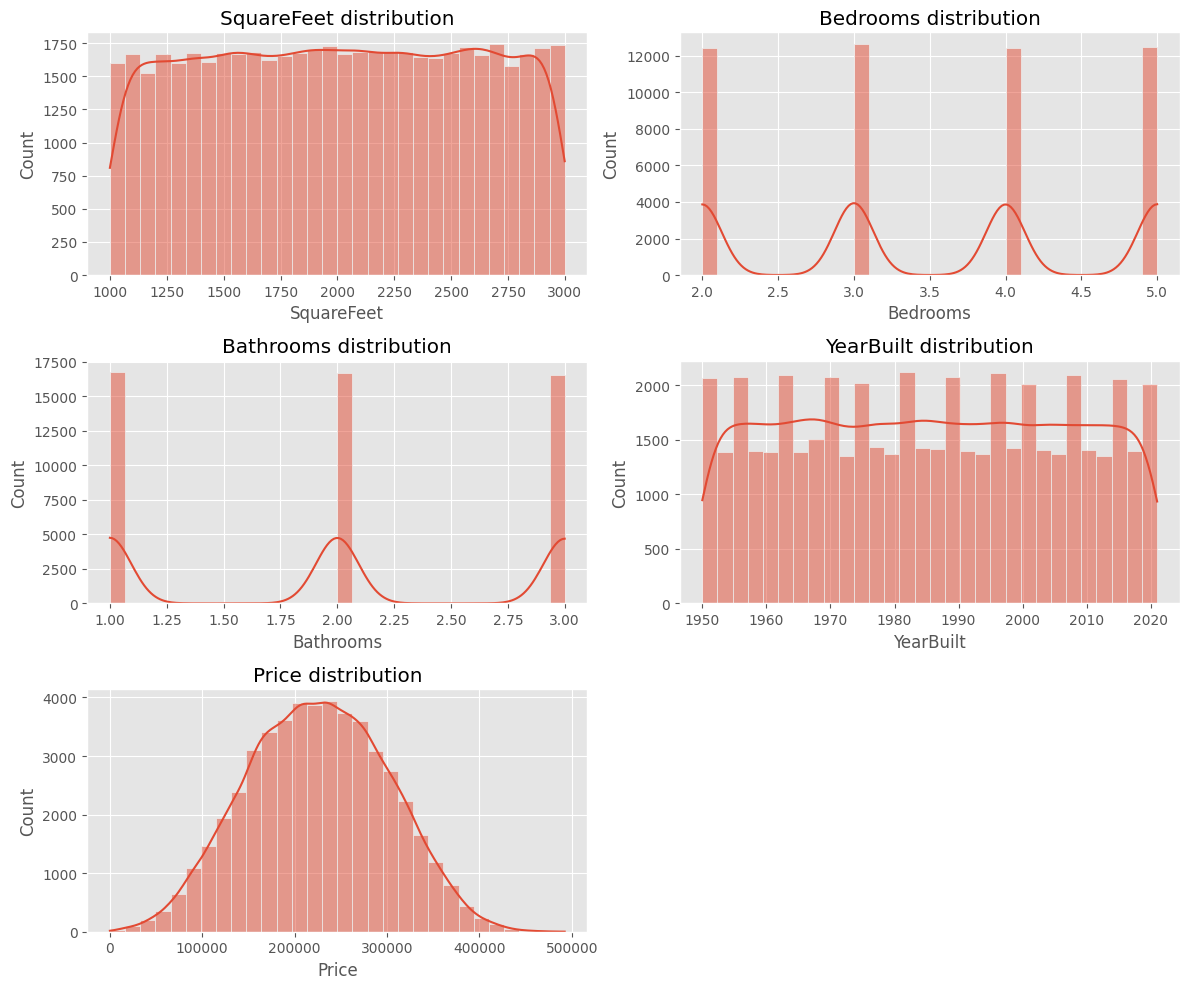

In [11]:
exp_cols = ["SquareFeet","Bedrooms","Bathrooms","YearBuilt",'Price']
plt.figure(figsize=(12,10))
for i, column in enumerate(exp_cols):
    plt.subplot(3,2, i+1)
    sns.histplot(data=df, x=column, kde=True, bins=30)
    plt.title(f'{column} distribution')
    plt.tight_layout()

# **Step 4: Feature Relationships**

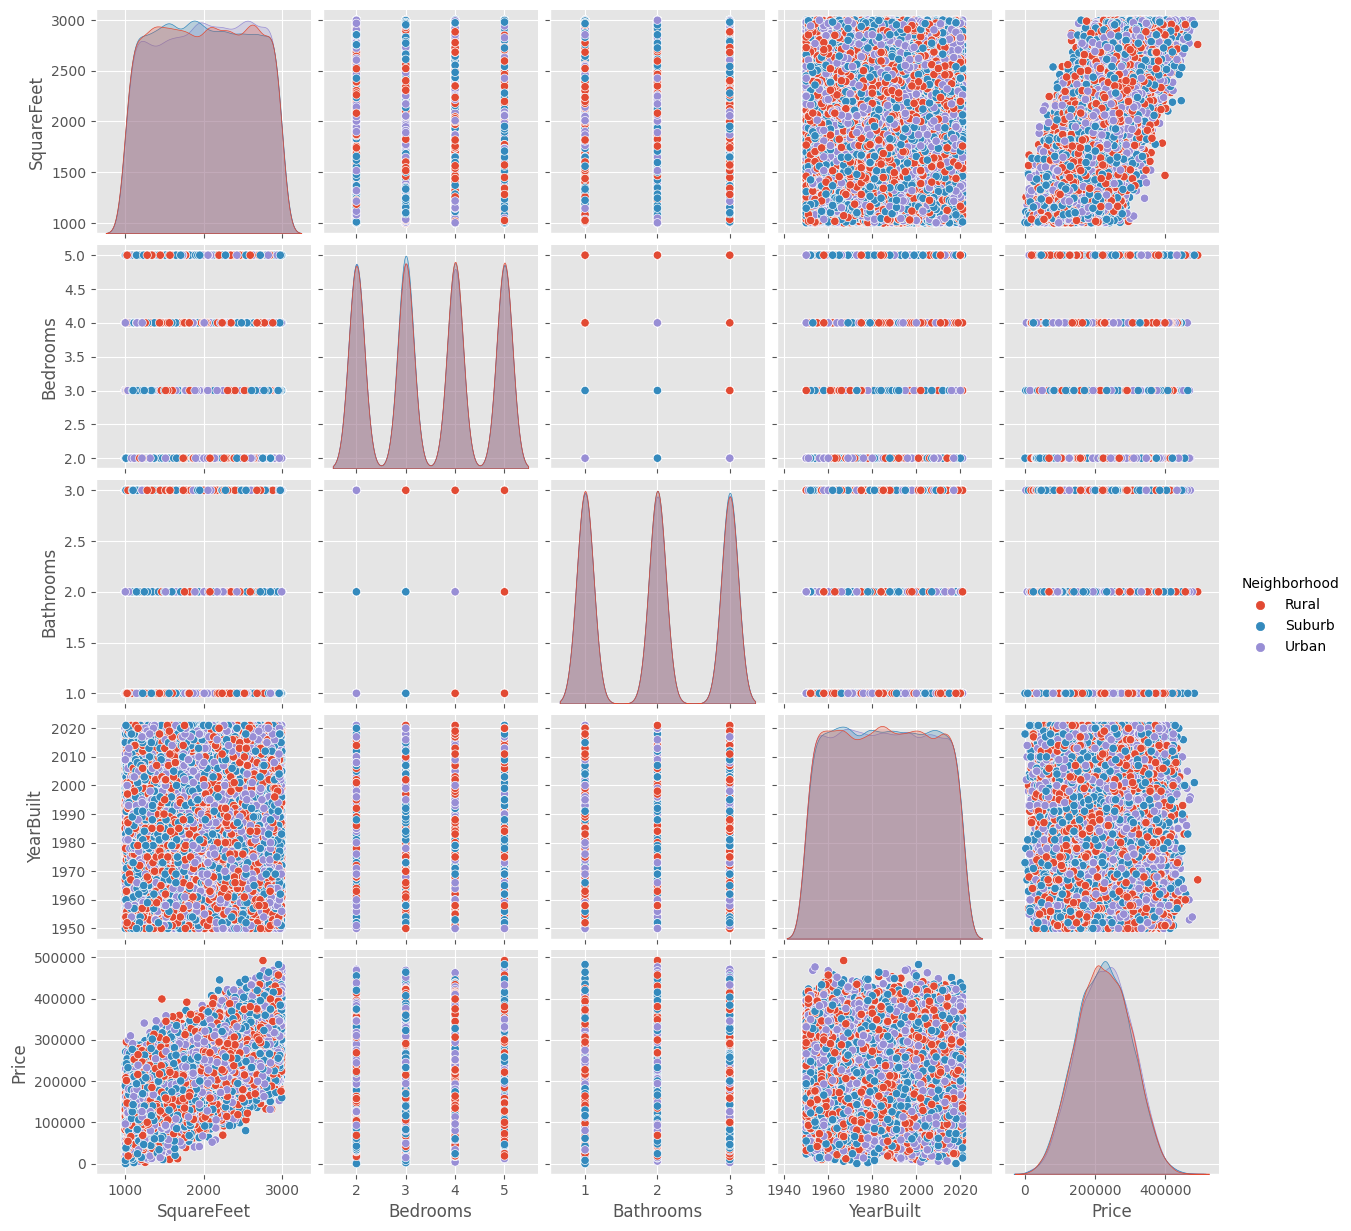

In [12]:
sns.pairplot(df,
             vars=["SquareFeet","Bedrooms","Bathrooms","YearBuilt",'Price'],
            hue='Neighborhood')
plt.show()

<Axes: >

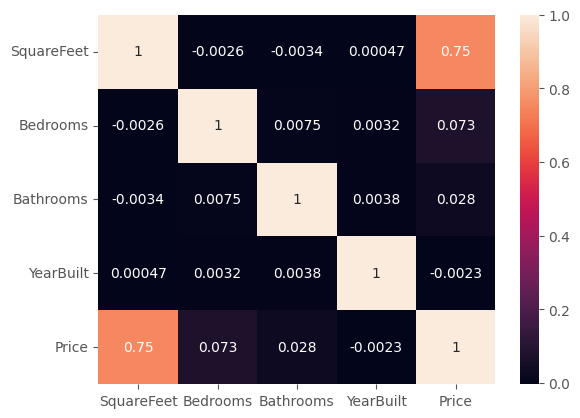

In [13]:
df_corr = df[["SquareFeet","Bedrooms","Bathrooms","YearBuilt",'Price']].dropna().corr()
sns.heatmap(df_corr, annot=True)

* Appears that only Squarefeet and Price have decently strong linear relationship (0.75)

In [14]:
df

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065
...,...,...,...,...,...,...
49995,1282,5,3,Rural,1975,100080.865895
49996,2854,2,2,Suburb,1988,374507.656727
49997,2979,5,3,Suburb,1962,384110.555590
49998,2596,5,2,Rural,1984,380512.685957


# **Step 5: Apply Baseline XGBoost to predict prices (Model 1)**

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [16]:
#Load the training and validation sets in X_train, X_valid, y_train, and y_valid. The test set is loaded in X_test.

from sklearn.model_selection import train_test_split

# Read the data
X = df

In [17]:
# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['Price'], inplace=True)
y = X.Price            
X.drop(['Price'], axis=1, inplace=True)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)

In [18]:
# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)

X_train, X_valid = X_train.align(X_valid, join='left', axis=1)

In [19]:
from xgboost import XGBRegressor

# Define the model
my_model_1 = XGBRegressor(random_state=0)

# Fit the model

my_model_1.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [20]:
#Obtain run 1 result
from sklearn.metrics import mean_absolute_error

# Get predictions
predictions_1 = my_model_1.predict(X_valid)

# Calculate MAE
mae_1 = mean_absolute_error(predictions_1, y_valid)

#Uncomment to print MAE
print("Mean Absolute Error:" , mae_1)

Mean Absolute Error: 40697.82680893489


# **Step 6: Adjusted XGBoost to predict prices (Model 2)**

In [21]:
# Define the model
my_model_2 = XGBRegressor(n_estimators=1000, learning_rate=0.04, n_jobs=4)

# Fit the model
my_model_2.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

# Get predictions
predictions_2 = my_model_2.predict(X_valid)

# Calculate MAE
mae_2 = mean_absolute_error(predictions_2, y_valid)

#Uncomment to print MAE
print("Mean Absolute Error:" , mae_2)

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Mean Absolute Error: 40082.06614004178


# **Step 7: Fine-tune Model (Hyperparameter tuning) - Model 3**
* Perform hyperparameter tuning using randomized search cross-validation for a regression problem. It uses several regression models:

**Gradient Boosting Regressor (gb_regressor):**
The model is created using the GradientBoostingRegressor from scikit-learn with the mean absolute error (mae) as the criterion.

**CatBoost Regressor (model):**
The model is created using the CatBoostRegressor from the CatBoost library with mean absolute error (MAE) as the loss function. It runs silently without printing logs.

**Random Forest Regressor (rf_regressor):**
The model is created using the RandomForestRegressor from scikit-learn.

**XGBoost Regressor (xgboost):**
The model is created using the XGBRegressor from the XGBoost library. 
Hyperparameter tuning is performed using a predefined set of parameters in the param_Xg dictionary.

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [23]:
gb_regressor = GradientBoostingRegressor(criterion = "mae")
model = CatBoostRegressor(loss_function='MAE', silent = True)
rf_regressor = RandomForestRegressor()
xgboost = XGBRegressor()

param_Xg = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]
          }
param_grid_gb = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [ 3, 5, 7],
}
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [ 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
param_grid = {'max_depth' : [2, 4, 8, 10, 12],
              'n_estimators' : [100, 200, 300],
              'max_features' : ['auto', 'sqrt'],
              "criterion" : ["friedman_mse", "mse", "mae"]}

# Create a GridSearchCV object
grid_gb = RandomizedSearchCV(
    estimator = model ,
    param_distributions = param_grid_gb,
    scoring = 'neg_mean_absolute_error',
    n_jobs = 4,
    verbose=True, 
    cv = 10,
     )
 
grid_gb.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7af05a48cfd0>,
                   n_jobs=4,
                   param_distributions={'depth': [4, 6, 8],
                                        'iterations': [50, 100, 200],
                                        'l2_leaf_reg': [3, 5, 7],
                                        'learning_rate': [0.01, 0.1]},
                   scoring='neg_mean_absolute_error', verbose=True)

In [24]:
print(grid_gb.best_params_)
-grid_gb.best_score_

{'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 100, 'depth': 4}


39866.374713448386

In [25]:
best_rf_params = grid_gb.best_params_
model = CatBoostRegressor(**best_rf_params)
y_pred= model.fit(X_train,y_train)

0:	learn: 71976.0725801	total: 5.77ms	remaining: 571ms
1:	learn: 68554.2915195	total: 9.76ms	remaining: 478ms
2:	learn: 65631.2562815	total: 13.5ms	remaining: 436ms
3:	learn: 63199.8772580	total: 17.3ms	remaining: 416ms
4:	learn: 61085.2071312	total: 21.3ms	remaining: 405ms
5:	learn: 59307.1736756	total: 25ms	remaining: 392ms
6:	learn: 57825.3440856	total: 28.5ms	remaining: 378ms
7:	learn: 56521.6189708	total: 31.9ms	remaining: 367ms
8:	learn: 55424.9503600	total: 36.2ms	remaining: 366ms
9:	learn: 54535.3146816	total: 40.1ms	remaining: 361ms
10:	learn: 53776.8717047	total: 43.5ms	remaining: 352ms
11:	learn: 53168.1560770	total: 46.8ms	remaining: 343ms
12:	learn: 52654.8770599	total: 50.2ms	remaining: 336ms
13:	learn: 52229.8081957	total: 53.5ms	remaining: 329ms
14:	learn: 51857.7961145	total: 57ms	remaining: 323ms
15:	learn: 51543.2562116	total: 60.4ms	remaining: 317ms
16:	learn: 51278.8740051	total: 64ms	remaining: 312ms
17:	learn: 51055.4846958	total: 67.5ms	remaining: 308ms
18:	lear

In [26]:
y_pred = model.predict(X_valid)
mean_absolute_error(y_pred, y_valid)

40033.876393529456

# **Step 8: Overall Summary**

* Model 1 (XGBoost): MAE = **40697**
* Model 2 (Adjusted XGBoost): MAE = **40082**
* Model 3 (Hyperparameter Tuning - CatBoost): MAE = **40033**
